# Population Dynamics and Theta Rhythm Phase Precession of  Hippocampal Place Cell Firing: A Spiking Neuron Model

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
J1 = 0.015       # maximum excitatory strength
J2 = 0.02        # other strengthes
l = 0.15         # decay constant of excitatory interactions
Sigma = 1.8      # weights factor

V_res = 0.85     # resting state of membrane potential
V_th = 1.        # spike threshold
tau_mem = 20.    # time constant of membrane potential
tau_ex = 6.      # time constant of excitatory synaptic current
tau_in = 4.      # time constant of inhibitory synaptic current
S_ex = 0.2       # reliability of E synaptic transmission
S_in = 0.7       # reliability of I synaptic transmission
lambda_e = 0.03    # degree of place-specific E input modulation
lambda_i = 0.02    # degree of place-specific I input modulation

I0_ex = 1.0         # input current baseline
I0_in = 1.03        # input current baseline
T = 1000/7       # period of inhibitory input

num_E = 400      # num of E neurons 
num_I = 100      # num of I neurons 
num_ALL = num_E+num_I # num of all neurons 

time_MOVING = 4000 # time of rat moving
dt = 2             # time step for simulation

rand_choices = [0, 1]

## 1. Dynamics Definiation

**The synaptic interactions**

Between the pyramidal neurons:

$
J_{i j}^{e x}=\sigma_{i j} J_{1} \exp \left(-\frac{\left|x_{i}-x_{j}\right|}{l}\right)
$

$
\begin{aligned}
\sigma_{i j} &=1, & & i<j \\
&=\sigma, & & i>j
\end{aligned}
$

For inhibitory hippocampal neurons, their connections with each other and with the excitatory neurons are uniform,




In [3]:
def get_ee_w(sigma, xi, xj):
    return sigma*J1*np.exp(-np.abs(xi-xj)/l)

**Dynamics of the membrane potential of each neuron**

$
\tau \frac{d V_{i}}{d t}=-V_{i}+I_{i}^{s}(t)+I_{i}^{e x t}(t)
$

$
I^{s}(t)=I^{e x}(t)-I^{i n}(t)
$

In [4]:
def fr_sigmoid(v):
    return 1 / (1 + np.exp(-x))

def get_avg_mem_dv(v, i):
    return (-v+i)/tau_mem

**E/I synaptic current**

$
\frac{d I_{i}^{e x}(t)}{d t}=-\frac{I_{i}^{ex}(t)}{\tau^{e x}}+s^{ex}(t) \sum_{j} J_{i j}^{e x} \delta\left(t-t_{j}^{ex}\right)
$

$
\frac{d I_{i}^{i n}(t)}{d t}=-\frac{I_{i}^{i n}(t)}{\tau^{i n}}+s^{i n}(t) \sum_{j} J_{i j}^{i n} \delta\left(t-t_{j}^{i n}\right)
$

In [5]:
def get_syn_di(i, syn_tau, s, Jij, spike_j):
    i_decay = -i/syn_tau 
    i_rec =  s*np.dot(Jij, spike_j)
    return i_decay + i_rec

**External Inputs**

$
I_{i}^{e x t}(t)=I_{0}\left(1+\lambda_{e} \exp \left(-\frac{\left|x_{i}-x_{0}(t)\right|}{l}\right)\right)
$

$
I_{i}^{ext}(t)=I_{0}\left(1+\lambda_{i} \cos (2 \pi t / T)\right)
$

In [6]:
def get_ext_e_i(xi, x0_t):
    return I0_ex*(1+lambda_e*np.exp(-np.abs(xi-x0_t)/l))

def get_ext_i_i(t, period):
    return I0_in*(1+lambda_i*np.cos(2*np.pi*t/period))

**The traversal of the apparatus in 4000 ms by the rat moving with a constant speed**

$x_{0}(t)=t / 4000$

In [7]:
def get_x0(t):
    return t/time_MOVING

## 2. Network Definiation & Initialization 

### 2.1 Position Labels

In [8]:
def get_position_labels(max_p=1):
    return np.linspace(0,max_p,num_E)

### 2.2 Recurrent Synaptic Strengthes

In [9]:
def init_rec_w(x_labels):
    W_rec = np.ones((num_ALL, num_ALL))*J2

    for i in range(num_E):
        for j in range(num_E):
            sigma_ij = 1 if i<j else Sigma
            W_rec[i][j] = get_ee_w(sigma=sigma_ij, xi=x_labels[i],xj=x_labels[j])

    np.fill_diagonal(W_rec, 0.)

    return W_rec

### 2.3 Network Configuration

In [10]:
class ThetaRhythmSpikeNetwork():
    def __init__(self,tot_time=time_MOVING, ext_t=T):
        self.x_labels = get_position_labels(1)
        self.W_rec = init_rec_w(self.x_labels)
        self.time_map = np.arange(0, tot_time, dt)
        self.step_num = len(self.time_map)
        self.Vs = np.zeros((num_ALL, self.step_num))
        self.Vs[:,0] = V_res
        self.Is = np.zeros((num_ALL, self.step_num))
        self.I_exs = np.zeros((num_ALL, self.step_num))
        self.I_ins = np.zeros((num_ALL, self.step_num))
        self.Ss = np.zeros((num_ALL, self.step_num))

        self.ext_t = ext_t

    def simulation(self,):
        for curr_ts in range(1, self.step_num):
            curr_x0 = get_x0(self.time_map[curr_ts])

            for n in range(0, num_ALL):
                prev_iex = self.I_exs[n, curr_ts-1]
                prev_iin = self.I_ins[n, curr_ts-1]
                prev_v = self.Vs[n, curr_ts-1]
                prev_s = self.Ss[:, curr_ts-1]

                curr_s_ex = np.random.choice(rand_choices)*S_ex
                curr_s_in = np.random.choice(rand_choices)*S_in

                if n < num_E:
                    curr_i_ext = get_ext_e_i(xi=self.x_labels[n], x0_t=curr_x0)
                else:
                    curr_i_ext = get_ext_i_i(self.time_map[curr_ts],period=self.ext_t)

                curr_i_ex = dt*get_syn_di(prev_iex, tau_ex, curr_s_ex, 
                                       self.W_rec[:num_E,n], prev_s[:num_E])+prev_iex
                curr_i_in = dt*get_syn_di(prev_iin, tau_in, curr_s_in, 
                                       self.W_rec[num_E:,n], prev_s[num_E:])+prev_iin

                curr_i = curr_i_ex-curr_i_in+curr_i_ext

                self.Is[n,curr_ts]=curr_i
                self.I_exs[n, curr_ts] = curr_i_ex
                self.I_ins[n, curr_ts] = curr_i_in

                curr_v = dt*get_avg_mem_dv(v=prev_v, i=curr_i)+prev_v
                
                if curr_v >= V_th:
                    self.Vs[n, curr_ts] = V_res
                    self.Ss[n, curr_ts] = 1.
                else:
                    self.Vs[n, curr_ts] = curr_v
                    self.Ss[n, curr_ts] = 0.


## 3. Simulation & Visualization

In [11]:
snn = ThetaRhythmSpikeNetwork(2000)
snn.simulation()

In [17]:
def plot_spike_activity(sn, s_t, e_t):
    params = {'legend.fontsize': 'x-large',
            'figure.figsize': (10, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}
    s_t = int(s_t/dt)
    e_t = int(e_t/dt)

    plt.rcParams.update(params)
    ss = sn.Ss[:,s_t:e_t]
    ts = np.arange(0, sn.step_num)[s_t:e_t]

    t_len = np.shape(ss)[1]
    spike_n, spike_t = np.where(ss[:num_E]==1.)
    fig, ax = plt.subplots(nrows=2, gridspec_kw={'hspace': 0.,'height_ratios': [3, 1]})
    
    ax[0].scatter(spike_t, spike_n, marker='o', color='black',s=20, linewidth=1)
    ax[1].plot([get_ext_i_i(sn.time_map[t],period=sn.ext_t) for t in ts])

    ax[0].set_ylim([0, num_E])
    ax[0].set_xlim([0, t_len])
    ax[0].set_xticks([]) 
    ax[1].set_xlim([0, t_len])
    plt.show()



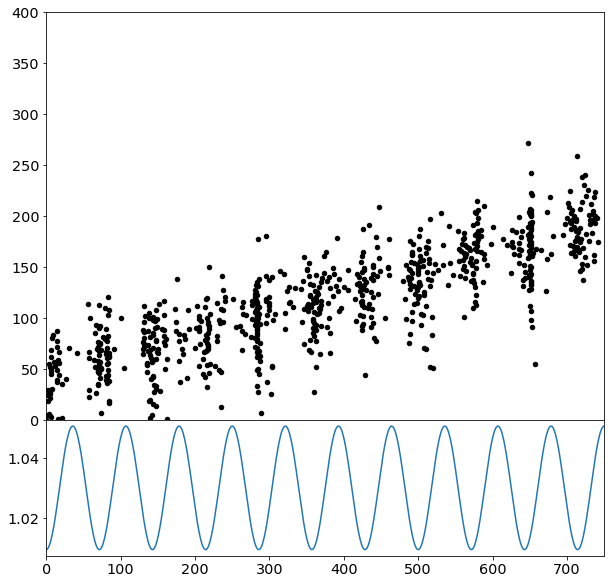

In [20]:
plot_spike_activity(snn,500,2000)

In [ ]:
n_ids = list(range(100,105))
spike_recording = []

for t in range(50):
    print('record itr',t)
    snn = ThetaRhythmSpikeNetwork(2000)
    snn.simulation()
    spike_recording.append(snn.Ss[n_ids])

record itr 0
record itr 1
record itr 2
record itr 3
record itr 4
record itr 5
record itr 6
record itr 7
record itr 8
record itr 9
record itr 10
record itr 11
record itr 12
record itr 13
record itr 14
record itr 15
record itr 16
record itr 17
record itr 18
record itr 19
record itr 20
record itr 21
record itr 22
record itr 23
record itr 24
record itr 25


In [14]:
def get_phase_position(sn, n=175, s_cycle=8):
    s_t = int(T*s_cycle/dt)
    e_t = int(T*(s_cycle+2)/dt)
    phase_map = np.linspace(0,720,e_t-s_t)
    # spike_n, spike_t = np.where(ss[n,]==1.)
    spike_t = np.where(sn.Ss[n,s_t:e_t]==1.)
    degrees = phase_map[spike_t]
    x0s = [get_x0(sn.time_map[ts+s_t]) for ts in spike_t]
    print(degrees)
    xn = sn.x_labels[n]
    print(xn, x0s)
    positions = x0s-xn
    print(positions)

get_phase_position(snn)

[]
0.43859649122807015 [array([], dtype=float64)]
[]


In [15]:
def plot_current(n, nn):
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    plt.plot(nn.Is[n,],label='I')
    plt.plot(nn.I_exs[n,],label='I_ex')
    plt.plot(-nn.I_ins[n,],label='I_in')
    plt.legend()
    plt.show()

def plot_voltage(n, nn):
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    plt.plot(nn.Vs[n,],label='V')
    plt.legend()
    plt.show()